# TASK-2: Keyword-Based Song Classification
This notebook processes a dataset of songs with keywords and genres. The goal is to compute keyword vectors using a variation of TF-IDF for better categorization,reduce the dimensions for the vectors using PCA and combine these vectors into one and group similar songs . 

## Importing required libraries 

we need libraries such as:
- **pandas**: For handling structured data.
- **numpy**: For numerical computations.
- **matplotlib.pyplot**: (Currently not used) Can be used for visualization.

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the Dataset
The dataset contains song keywords and genres.
- `song_id` column is dropped as it's not needed for processing.
- First few rows of the dataset are displayed.

In [2]:
#importing the dataset
df =pd.read_csv('data.csv')
df=df.drop('song_id',axis=1)
print(df)

    keyword_1  keyword_2  keyword_3      genre
0      guitar      happy  distorted       rock
1       brass  energetic    melodic  classical
2       banjo      happy   acoustic    country
3       synth  energetic      heavy    hip-hop
4       synth  energetic       slow    hip-hop
..        ...        ...        ...        ...
142     synth      angry    melodic    hip-hop
143    guitar  energetic       fast        pop
144    guitar      happy   rhythmic        pop
145     synth     mellow  danceable        pop
146     synth  emotional       slow        pop

[147 rows x 4 columns]


## Vectorizaton of keywords
we have two popular methods for word2vec , BoW and TF-IDF . 
TF-IDF assigns weights based on term importance, reducing the impact of commonly used words.BoW treats all words equally, leading to less meaningful representations.
So due to these pros of TF-IDF over BoW , we use TF-IDF in our task for generating vectors.

## Bag of words 
In BoW, the corresponding component value for the vector is equal to the frequency of the word in the document.


In [3]:
#bag of words function
def bag_of_words(keyword,unique_keywords):
    vector=[0 for _ in unique_keywords] # creating an empty list for vector
    for i in range(0,len(unique_keywords)):
        if keyword==unique_keywords[i]:
            vector[i]+=1 # appending the frequency of the word as the component of the vector
    return vector # returning the word-vector

# TF-IDF
TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used in information retrieval and text mining to evaluate the importance of a word in a document relative to a collection (or corpus) of documents.

In [4]:
#TF-TDF function
def tfidf(word,document,list_of_documents):
    if_value=If(word,document) #calling the IF function to calculate the "IF" value
    tdf_value=tdf(word,list_of_documents)#calling the TDF function to calculate the "TDF" value
    return if_value*tdf_value # return the IF-TDF value for the corresponding keyword

#IF function
def If(word,document):
    frequency_of_word=document.count(word)# taking the frequency of the word in the document
    total_words=len(document) # total number of words
    if total_words > 0 :
        return (frequency_of_word+1/total_words)
    else :
        return 0 # return 0 if the document is empty
#TDF function
def tdf(word,list_of_documnets):
    total_documents=len(list_of_documnets)# total number of documents
    count=0
    for document in list_of_documnets:
        if word in document:
            count+=1
    word_containing_documents=count# nuber of documents containing the keyword
    return np.log((total_documents)/(word_containing_documents)) # returning the value of IDF 
    


#vector creating function
def vectorization(keyword,keywords_list,tfidf_values):
    vector=[] # creating an empty list for vector
    for i in range(0,len(keywords_list)):
        if keyword==keywords_list[i]:
            vector.append(tfidf_values[i]) # appending the tfidf value of the keyword as components
        else:
            vector.append(0)
    return vector

### Advantages of TF-IDF over BoW:
     
  TF-IDF assigns weights based on term importance, reducing the impact of commonly used words.BoW treats all words equally, leading to less meaningful representations.


Computing vectors for each keyword 

In [5]:
songs_list = df[['keyword_1', 'keyword_2', 'keyword_3']].values.tolist() # list of all songs
#function for computing the vectors
def compute_vectors(keyword_column):
    keyword_list = df[keyword_column].drop_duplicates().to_list()#taking the unique keywords as dimensions for the vector
    unique_songs = df.drop_duplicates(subset=[keyword_column])#taking a list of songs containing the unique keywords 
    unique_songs_list = unique_songs[['keyword_1', 'keyword_2', 'keyword_3']].values.tolist()
    idtdf_values = [tfidf(keyword, doc, songs_list) for keyword, doc in zip(keyword_list, unique_songs_list)] # creating a list of tfidf value for the uniqu keywords
    return idtdf_values,[vectorization(df.iloc[i][keyword_column], keyword_list, idtdf_values) for i in range(len(songs_list))]

keyword_1_tfidf_values,keyword_1_vectors = compute_vectors('keyword_1')
keyword_2_tfidf_values,keyword_2_vectors = compute_vectors('keyword_2')
keyword_3_tfidf_values,keyword_3_vectors = compute_vectors('keyword_3')
print(keyword_1_vectors[:3])
print(keyword_2_vectors[:3])
print(keyword_3_vectors[:3])

[[np.float64(1.0880604225107988), 0, 0, 0, 0, 0], [0, np.float64(3.4567164186404877), 0, 0, 0, 0], [0, 0, np.float64(4.264897490067575), 0, 0, 0]]
[[np.float64(2.1189802734887744), 0, 0, 0, 0, 0, 0, 0, 0], [0, np.float64(2.259460961032543), 0, 0, 0, 0, 0, 0, 0], [np.float64(2.1189802734887744), 0, 0, 0, 0, 0, 0, 0, 0]]
[[np.float64(4.507992899126181), 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, np.float64(2.259460961032543), 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, np.float64(3.7242773459233556), 0, 0, 0, 0, 0, 0, 0]]


## PCA (Principle Component Analysis)

PCA can tell us which category (or feature) is the most valuable for clustering the data

In [6]:
# creating the class for the algorithm 
class pca:
  def __init__(self,n_components):#here n_components are the final umber of dimensions required
    self.n_components=n_components
    self.components=None 
    self.mean=None

  def fit(self,X):
    #calculating the mean for each feature of X(the input dataset)
    self.mean=np.mean(X,axis=0)
    X=X-self.mean
    #calculating the covariance matrix of the input data
    covar=np.cov(X.T)
    #calulating the eigenvectors , eigenvalues for the covariance matrix
    eigenvalues,eigenvectors=np.linalg.eig(covar)
    #sorting the eigenvectors according to their corresponding eigenvalues
    eigenvalues=eigenvalues.transpose()
    idxs=np.argsort(eigenvalues)[::-1]#::-1 is for decreasing order
    eigenvalues=eigenvalues[idxs]
    eigenvectors=eigenvectors[:,idxs]
    #storing the  first n eigenvalues
    self.components=eigenvectors[0:self.n_components]
  def transform(self,X):
    #projecting the data-points into the new dimensions using dot product. 
    X = X-self.mean
    return np.dot(X,self.components.T) # returing the projected data

Calculating the dimensionally reduced vectors for each keyword

In [7]:
#for keyword_1
pca_1=pca(n_components=2)
pca_1.fit(keyword_1_vectors)
reduced_keyword1_vectors=pca_1.transform(keyword_1_vectors)
print(reduced_keyword1_vectors[:3])

#for keyword_2
pca_2=pca(n_components=2)
pca_2.fit(keyword_2_vectors)
reduced_keyword2_vectors=pca_2.transform(keyword_2_vectors)
print(reduced_keyword1_vectors[:3])

#for keyword_3
pca_3=pca(n_components=2)
pca_3.fit(keyword_3_vectors)
reduced_keyword3_vectors=pca_3.transform(keyword_3_vectors)
print(reduced_keyword1_vectors[:3])


[[ 0.35513958  0.45334571]
 [ 0.4529401  -2.57134484]
 [-0.07962937  1.61737861]]
[[ 0.35513958  0.45334571]
 [ 0.4529401  -2.57134484]
 [-0.07962937  1.61737861]]
[[ 0.35513958  0.45334571]
 [ 0.4529401  -2.57134484]
 [-0.07962937  1.61737861]]


## Combining all the three vectors into one
we are using the Weighted Mean method to combine the vectors into one  
We can  calculatethe weights for the respective 2D vectors using their respective variances.<br>
Higher variance refers to more importance which can be represented by giving higher weight<br>
since in our dataset the influence of different keywords on deciding of genre of the song is different. 

In [8]:
# combining all three vectors
weights=[]
reduced_whole_songs_vectors=[]
for i in range(0,len(songs_list)):
    var1 = np.var(reduced_keyword1_vectors[i])
    var2 = np.var(reduced_keyword2_vectors[i])
    var3 = np.var(reduced_keyword3_vectors[i])
    weights = np.array([var1, var2, var3])
    weights /= weights.sum()
    
    x_component = weights[0] * (reduced_keyword1_vectors[i][0]) + weights[1] * (reduced_keyword2_vectors[i][0])+ weights[2] * (reduced_keyword3_vectors[i][0])
    y_component= weights[0] * (reduced_keyword1_vectors[i][1]) + weights[1] * (reduced_keyword2_vectors[i][1])+ weights[2] * (reduced_keyword3_vectors[i][1])
    
    reduced_whole_songs_vectors.append([x_component,y_component])
# print(reduced_whole_songs_vectors[:3])
array_reduced_whole_songs=np.array(reduced_whole_songs_vectors)

## ploting the vectors in a plot for visualising the data

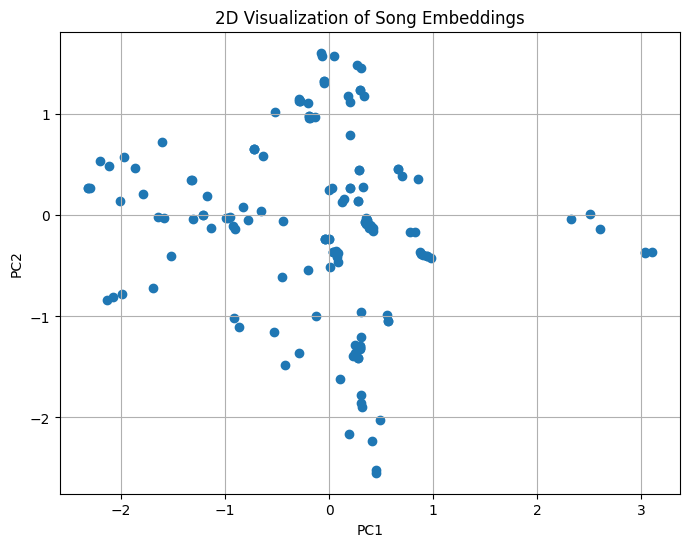

In [9]:

plt.figure(figsize=(8, 6))
plt.scatter(array_reduced_whole_songs[:, 0], array_reduced_whole_songs[:, 1])

# Adding labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D Visualization of Song Embeddings")
plt.grid(True)
plt.show()

## Clustering 
we are going to use the kmeans clustering method for the clustering the data points since it is very handy to use

In [10]:
#clustering

np.random.seed(42)
#definig a functions for calclating the distance the distance between the data points
def euclidean_distance(X1, X2):
   return np.linalg.norm(X1 - X2)

# creating the class for the algorithm 
class kmeans:
    def  __init__(self,k,max_reps=1000,plot_steps=False):
        self.k=k # number of cluster should the data points must be grouped into
        self.max_reps=max_reps #number of iterations for optimization 
        self.plot_steps=plot_steps # whether to plot the steps aor not
        self.clusters=[[] for _ in range(self.k)] # intailizing the clusters  as empty lists
        self.centroids=[] #intalizing the list of centroids for each cluster 
        #prediction function
    def predict(self,X):
        self.X=X # here X is the input dataset
        self.n_samples,n_features=X.shape 
          
        random_sample_idxs = np.random.choice(self.n_samples, self.k, replace=False)# choosing k data points for k clusters 
        self.centroids = [self.X[idx] for idx in random_sample_idxs] #assiging the data points as centroids of the clusters 
        for _ in range(0,self.max_reps):
            self.clusters=self.update_cluster()#creating the cluster
            old_centroids=self.centroids # storing the previous centroids bfore we update the centroids
            self.centroids=self.update_centroids() #updating the centroids 
            
            #checking the convergence
            #checking for any variations in the previous and present centriods
            if self.convergence(old_centroids):
                break
        return self.labels()
    
    def labels(self):
        n_samples,n_features=self.X.shape 
        label=np.empty(n_samples) #intializing the labels list 
        for cluster_indx , cluster in enumerate(self.clusters):
            for indx in cluster:
                label[indx]=cluster_indx #assigning the cluster to the datapoints
        return label #returning the labels
    
    #a function for updating the clusters
    def update_cluster(self):
        clusters=[[] for _ in range(self.k)]
        for idx,point in enumerate(self.X):
            distance=np.array([euclidean_distance(point,centroid) for centroid in self.centroids])
            centroid_index=np.argmin(distance) # checking which cluster centroid is nearest to the data point 
            clusters[centroid_index].append(idx) # appending the data point to the cluster
        return clusters
    # function for  updating centroids
    def update_centroids(self):
        centroids=[]
        for cluster_idx , cluster in enumerate(self.clusters):
            if len(cluster) > 0:
                mean = np.mean([self.X[idx] for idx in cluster], axis=0) # calculating the data center for each cluster
            else:
                mean = np.zeros(self.X.shape[1])
            
            centroids.append(mean)
        return centroids

    #function for calculating the convergence (i.e. variation between new and old centroids)
    def  convergence(self,old_centroids):
        distances=[euclidean_distance(old_centroids[i],self.centroids[i]) for i in range(self.k)]
        if sum(distances)==0:
            return True
        else :
            return False
    #fuction for calculating the Average Within-Cluster Sum of Squares (AWCSS)
    def compute_awcss(self):
        total_wcss = 0  # Initialize total WCSS
        
        for cluster_idx, cluster in enumerate(self.clusters):
            if len(cluster) > 0:  # Prevent errors for empty clusters
                points = np.array([self.X[idx] for idx in cluster])  # Extract actual data points
                centroid = np.array(self.centroids[cluster_idx])  # Get the centroid
                
                # Compute sum of squared distances of all points in the cluster
                total_wcss += np.sum((points - centroid) ** 2)
        
        return total_wcss / len(self.X)
    #function ploting the data
    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, cluster in enumerate(self.clusters):
            
            points = np.array([self.X[idx] for idx in cluster])
            ax.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)
        plt.legend()
        plt.show()

## Finding the optimal value for the K
In order to find the optimal value for the K ,we are using the elbow's method with variance as factor.Since, Variance explained directly shows how well the clustering represents the data.whereas,in WCSS, the values always decrease, but it's harder to pinpoint where the improvement diminishes because the scale is dataset-dependent.

### This the fuction for the elbow's method using WCSS

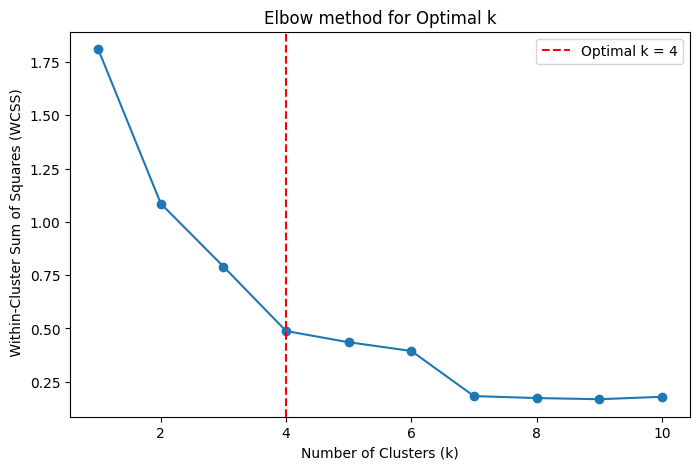

4


In [11]:
#function
def elbow_method(songs_vectors):
    wcss_values=[]#intializing the list for the WCSS values storage
    for i in range(1,11):# here we are assuming the max_value for K is 10
        model=kmeans(i)#training the model
        model.predict(np.array(songs_vectors))
        wcss_values.append((i,model.compute_awcss()))#appending the WCSS value to the list
       
    x1,y1=wcss_values[0] # first point of the graph
    x2,y2=wcss_values[9]# last point of the graph
    distances=[]
    denominator=np.sqrt(((x2-x1)**2)+((y2-y1)**2))
    for point in wcss_values:
        x,y=point
        distance=np.abs(((y2-y1)*x)-((x2-x1)*y)+(x2*y1-y2*x1))
        distances.append(distance/denominator)#appending the perpendicular distance to the list
    max_distance=max(distances)
    optimal_k=distances.index(max_distance)+1
    k_values=[i for i in range(1,11)]
    wcss_value=[wcss_values[i][1] for i in range(0,10)]
    plt.figure(figsize=(8, 5))
    plt.plot( k_values,wcss_value,marker='o', linestyle='-')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel(" Within-Cluster Sum of Squares (WCSS)")
    plt.title("Elbow method for Optimal k")
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.legend()
    plt.show()
    return optimal_k

optimal_k=elbow_method(np.array(reduced_whole_songs_vectors))
print(optimal_k)

### This the fuction for the elbow's method using variance-explained

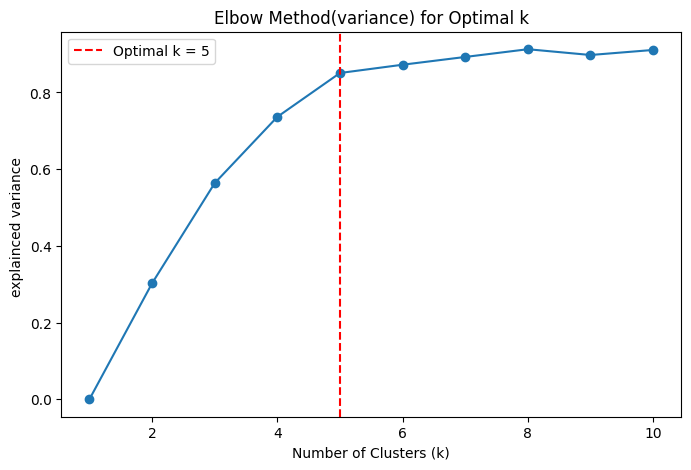

5


In [12]:
#fucntion
def elbow_method(songs_vectors):
    variance_values=[]#intializing the list for storing variances
    total_variance = np.var(songs_vectors, axis=0).sum() 
    for i in range(1,11):
        model=kmeans(i)#training the model
        model.predict(np.array(songs_vectors))
        within_cluster_variance = model.compute_awcss()  # Compute variance within clusters
        explained_variance = (total_variance - within_cluster_variance) / total_variance #calculating the explained variance
        variance_values.append((i,explained_variance)) #appending the value to the list
        
    x1,y1=variance_values[0]#first point of the graph
    x2,y2=variance_values[9]#last point of the graph
    distances=[]
    denominator=np.sqrt(((x2-x1)**2)+((y2-y1)**2))
    for point in variance_values:
        x,y=point
        distance=np.abs(((y2-y1)*x)-((x2-x1)*y)+(x2*y1-y2*x1))
        distances.append(distance/denominator)#appending the perpendicular distance to the list
    max_distance=max(distances)
    optimal_k=distances.index(max_distance)+1
    k_values=[i for i in range(1,11)]
    wcss_value=[variance_values[i][1] for i in range(0,10)]
    plt.figure(figsize=(8, 5))
    plt.plot( k_values,wcss_value,marker='o', linestyle='-')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("explainced variance ")
    plt.title("Elbow Method(variance) for Optimal k")
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.legend()
    plt.show()
    return optimal_k

optimal_k=elbow_method(np.array(reduced_whole_songs_vectors))#taking th eoptimal K value
print(optimal_k)

#### Here we are applying the K-Means algorithm

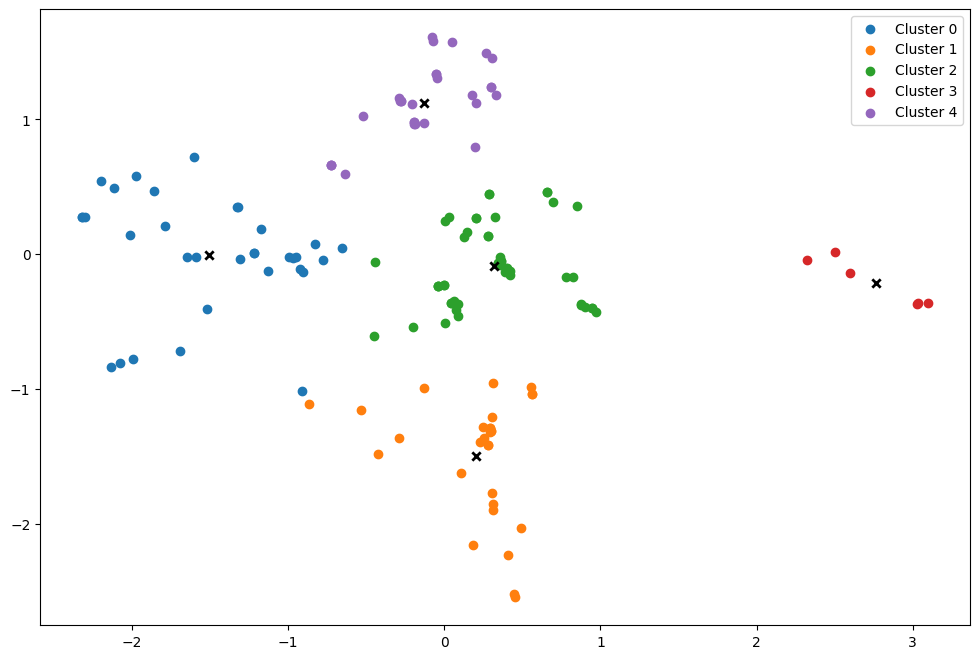

In [13]:
k = kmeans(k=optimal_k, max_reps=300, plot_steps=True)
y_pred=k.predict(np.array(reduced_whole_songs_vectors))
k.plot()
# print(y_pred)
clusters_list=k.clusters
# print(clusters_list)

### Calculating the clustering performance using silhouette score metric

In [14]:
def silhouette_score(X, labels):
    X = np.array(X)  
    labels = np.array(labels) 
    unique_labels = np.unique(labels)
    
    silhouette_scores = []
    
    for i in range(0,len(X)):
        current_cluster = labels[i]
        
        # Indices of the same cluster points
        same_cluster_idx = np.where(labels == current_cluster)[0]
        same_cluster = X[same_cluster_idx]
        #computing a(i) value : mean of distances within the same cluster
        if len(same_cluster) > 1:
            a_i = np.mean([euclidean_distance(X[i], point) for point in same_cluster if not np.array_equal(point, X[i])])
        else:
            a_i = 0
        
        # Computing b(i): mean nearest-cluster distance
        b_i = np.inf
        for label in unique_labels:
            if label == current_cluster:
                continue
            other_cluster_idx = np.where(labels == label)[0]
            other_cluster = X[other_cluster_idx]
            
            if len(other_cluster) > 0:
                b_cluster = np.mean([euclidean_distance(X[i], point) for point in other_cluster])
                b_i = min(b_i, b_cluster)
        
        # Computing the silhouette score for the point
        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
        silhouette_scores.append(s_i)
    
    return np.mean(silhouette_scores) # returning the mean of all scores

In [15]:
score = silhouette_score(reduced_whole_songs_vectors, y_pred)
print("Silhouette Score:", score)

Silhouette Score: 0.5420824557822562


## Analysis of dataset

# Percentage distribution of music genres in each cluster
Now we have to find the percentage distributon of music genres (i.e. the ground truths) in each cluster.

In [16]:
def genre_distribution(cluster_indices, genres):
    distributions = []
    
    for cluster in cluster_indices:
        genre_count = {}
        total = len(cluster)
        
        # Counting genres in the cluster
        for idx in cluster:
            genre = genres[idx]
            if genre in genre_count:
                genre_count[genre] += 1
            else:
                genre_count[genre] = 1
        
        # Calculating percentage for each genre in the cluster
        percentage_distribution = {}
        for genre, count in genre_count.items():
            percentage_distribution[genre] = (count / total) * 100
        
        distributions.append(percentage_distribution)
    
    return distributions

[{'classical': 48.484848484848484, 'pop': 30.303030303030305, 'hip-hop': 9.090909090909092, 'rock': 9.090909090909092, 'country': 3.0303030303030303}, {'classical': 37.93103448275862, 'rock': 13.793103448275861, 'pop': 20.689655172413794, 'country': 13.793103448275861, 'hip-hop': 13.793103448275861}, {'rock': 22.0, 'country': 20.0, 'pop': 22.0, 'hip-hop': 36.0}, {'country': 100.0}, {'rock': 41.37931034482759, 'country': 27.586206896551722, 'hip-hop': 17.24137931034483, 'pop': 13.793103448275861}]


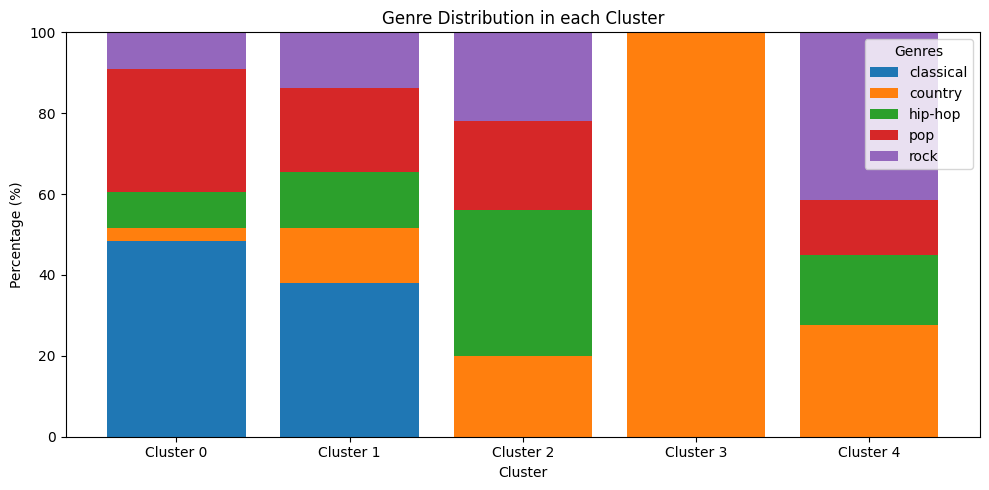

In [17]:
distributions = genre_distribution(clusters_list,df['genre'])
print(distributions)
all_genres = sorted(set([genre for dist in distributions for genre in dist.keys()]))  # Unique sorted genres
data = np.zeros((len(distributions), len(all_genres)))

# Filling the data matrix with genre percentages
for i, dist in enumerate(distributions):
    for j, genre in enumerate(all_genres):
        data[i, j] = dist.get(genre, 0)  # Default to 0 if genre is not in the cluster

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Create the stacked bar chart
bottoms = np.zeros(len(distributions))  # Initialize the bottom position for stacking

# Add bars for each genre in the cluster
for j, genre in enumerate(all_genres):
    ax.bar(range(len(distributions)), data[:, j], bottom=bottoms, label=genre)
    bottoms += data[:, j]  # Update the bottom position for the next genre

# Labels and title
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage (%)')
ax.set_title('Genre Distribution in each Cluster')
ax.set_xticks(range(len(distributions)))
ax.set_xticklabels([f'Cluster {i}' for i in range(len(distributions))])
ax.legend(title="Genres")

plt.tight_layout()
plt.show()

## Prediction 
Now that we have trained the model with the given dataset we can predict the genres of some new songs if the keywords are given

Creating the vectors for the new songs

In [18]:
new_songs_list=[["piano", "calm", "slow"], ["guitar", "emotional", "distorted"],["synth","mellow", "distorted"]]
new_keyword_1_vectors=[vectorization(new_songs_list[k][0],df['keyword_1'].drop_duplicates().to_list(),keyword_1_tfidf_values) for k in range(0,len(new_songs_list))]
new_keyword_2_vectors=[vectorization(new_songs_list[k][1],df['keyword_2'].drop_duplicates().to_list(),keyword_2_tfidf_values) for k in range(0,len(new_songs_list))]
new_keyword_3_vectors=[vectorization(new_songs_list[k][2],df['keyword_3'].drop_duplicates().to_list(),keyword_3_tfidf_values) for k in range(0,len(new_songs_list))]


pca_1_=pca(n_components=2)
pca_1_.fit(new_keyword_1_vectors)
reduced_new_keyword1_vectors=pca_1_.transform(new_keyword_1_vectors)

pca_2_=pca(n_components=2)
pca_2_.fit(new_keyword_2_vectors)
reduced_new_keyword2_vectors=pca_2_.transform(new_keyword_2_vectors)

pca_3_=pca(n_components=2)
pca_3_.fit(new_keyword_3_vectors)
reduced_new_keyword3_vectors=pca_3_.transform(new_keyword_3_vectors)



In [19]:
# combining all three vectors

new_reduced_songs_vectors=[]

for i in range(0,len(new_songs_list)):
    x_component = weights[0] * (reduced_keyword1_vectors[i][0]) + weights[1] * (reduced_keyword2_vectors[i][0])+ weights[2] * (reduced_keyword3_vectors[i][0])
    y_component= weights[0] * (reduced_keyword1_vectors[i][1]) + weights[1] * (reduced_keyword2_vectors[i][1])+ weights[2] * (reduced_keyword3_vectors[i][1])
    
    new_reduced_songs_vectors.append([x_component,y_component])
print(new_reduced_songs_vectors)

[[np.float64(0.3527554831219608), np.float64(0.508816750105809)], [np.float64(0.44398819325924405), np.float64(-2.513289295399267)], [np.float64(-0.061588599752379125), np.float64(1.6140953236316566)]]


## KNN(K-Nearest Neighbors) 
we use KNN since it is easy , non-scale dependent and there is no to train the model

In [20]:
#redefining the eucildean distance for vectors
def euclidean_distance(vec1, vec2):
    vec1, vec2 = np.array(vec1), np.array(vec2)
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

#creating the class
class knn:
    def __init__(self,X,y,k=11):
        self.k=k # number of nearest neighbors must br taken into consideration
        self.training_data=X # Input data
        self.training_labels=y# input labels
    def predict(self, x):
        # Computing distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.training_data]
        # Sorting by distance and return indices of the first k neighbors
        idx = np.argsort(distances)[: self.k]
        # Extracting the labels of the k nearest neighbor training samples
        k_neighbor_labels = [self.training_labels[i] for i in idx]

        unique_labels = list(set(k_neighbor_labels))
        label_counts = [k_neighbor_labels.count(label) for label in unique_labels]
        
        # Return the label with the highest frequency
        most_common_label = unique_labels[label_counts.index(max(label_counts))]
        
        return most_common_label

In [21]:
knn_model=knn(reduced_whole_songs_vectors,df['genre'])
predictions=[]
for i in range(0,len(new_reduced_songs_vectors)):
    predictions.append(knn_model.predict(new_reduced_songs_vectors[i]))
print(predictions) # predictions

['rock', 'classical', 'rock']


Saving predictions in a prediction file

In [22]:
# Creating  a prediction dataFrame
new_df = pd.DataFrame(new_songs_list, columns=["Instrument", "Mood", "Style"])
new_df["Genre"]=predictions
# saving to a csv file
filename = "predictions.csv"
new_df.to_csv(filename, index=True)
